In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

# --- FUNZIONI DI BASE ---

# Carica i dati da un file FITS e li converte in float64 per operazioni numeriche
def load_fits_data(filepath):
    with fits.open(filepath) as hdul:
        return hdul[0].data.astype(np.float64)

# Crea un master frame (bias, dark o flat) calcolando la mediana delle immagini
# Se specificato, sottrae un bias a ogni frame prima del calcolo della mediana
def compute_master_frame(file_pattern, n_files, bias=None):
    frames = [load_fits_data(file_pattern % i) for i in range(1, n_files + 1)]
    frames = np.array(frames)
    if bias is not None:
        frames = frames - bias
    return np.median(frames, axis=0)

# Normalizza il flat dividendo per il valore medio dell'immagine
def normalize_flat(flat):
    return flat / np.mean(flat)

# Applica tutte le correzioni a un'immagine scientifica:
# - sottrae il master bias
# - sottrae il master dark
# - divide per il master flat
def calibrate_image(sci_data, master_bias, master_dark, master_flat):
    data_debiased = sci_data - master_bias
    data_dark_corrected = data_debiased - master_dark
    return data_dark_corrected / master_flat

# Salva i dati ridotti in un nuovo file FITS
def save_fits(data, output_path):
    hdu = fits.PrimaryHDU(data.astype(np.float32))  # salviamo in float32 per compatibilità
    hdu.writeto(output_path, overwrite=True)

# Visualizza l'immagine con matplotlib
def show_image(data, title='', vmin=None, vmax=None):
    plt.figure(figsize=(6, 6))
    plt.title(title)
    plt.imshow(data, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.show()

# --- RIDUZIONE DI UNA SINGOLA IMMAGINE ---

# Riduce un'immagine scientifica completa: bias, dark, flat e salvataggio
def reduce_image(path, sci_filename, out_filename, n_bias=10, n_dark=10, n_flat=10):
    # Percorsi ai file
    sci_path = os.path.join(path, 'sci', sci_filename)
    calib_path = os.path.join(path, 'calib')
    
    # Carica l'immagine scientifica
    sci_data = load_fits_data(sci_path)
    
    # Costruisce il master bias
    bias_pattern = os.path.join(calib_path, 'bias-%04i.fit')
    master_bias = compute_master_frame(bias_pattern, n_bias)
    
    # Costruisce il master dark, sottraendo prima il bias
    dark_pattern = os.path.join(calib_path, 'dark-%04i_15s.fit')
    master_dark = compute_master_frame(dark_pattern, n_dark, bias=master_bias)
    
    # Costruisce il master flat, sottraendo sia bias che dark
    flat_pattern = os.path.join(calib_path, 'flat-%04i_R.fit')
    master_flat = compute_master_frame(flat_pattern, n_flat, bias=master_bias + master_dark)
    master_flat = normalize_flat(master_flat)
    
    # Riduce l'immagine scientifica
    reduced_data = calibrate_image(sci_data, master_bias, master_dark, master_flat)
    
    # Salva l'immagine ridotta
    save_fits(reduced_data, os.path.join(path, 'reduced', out_filename))
    
    # Mostra il risultato
    med = np.median(reduced_data)
    show_image(reduced_data, title=out_filename, vmin=med - 100, vmax=med + 100)
    
# --- RIDUZIONE AUTOMATICA DI TUTTE LE IMMAGINI ---

# Riduce automaticamente tutte le immagini della serie specificata
def batch_reduce_images(path, start=1, end=245, prefix='SZ_Lyn-', suffix='_R.fit'):
    # Crea la cartella di output se non esiste
    os.makedirs(os.path.join(path, 'reduced'), exist_ok=True)

    # Itera su tutte le immagini scientifiche
    for i in range(start, end + 1):
        fname = f"{prefix}{i:04d}{suffix}"              # Nome del file di input
        outname = f"{prefix}{i:04d}_reduced.fit"        # Nome del file di output
        try:
            reduce_image(path, fname, outname)          # Riduce e salva
        except Exception as e:
            print(f"Errore con {fname}: {e}")         # Stampa eventuali errori


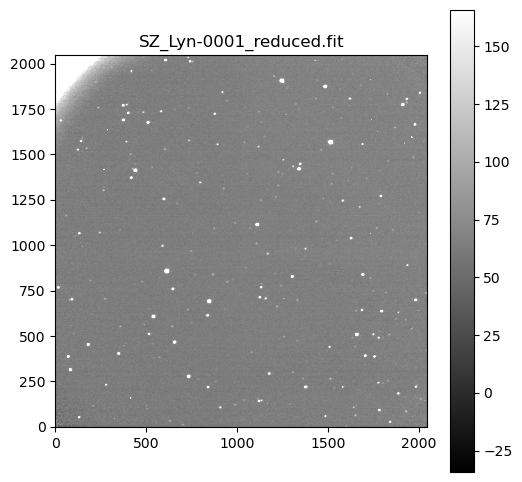

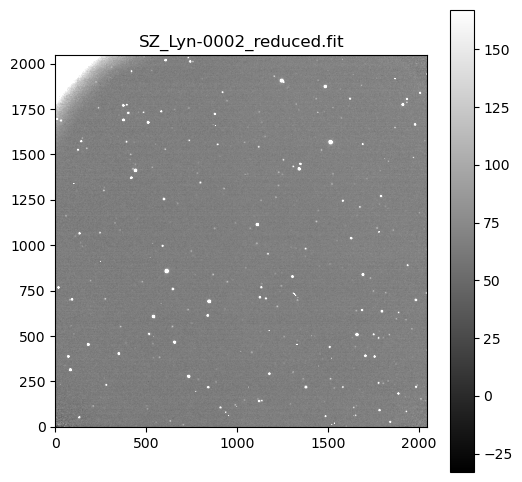

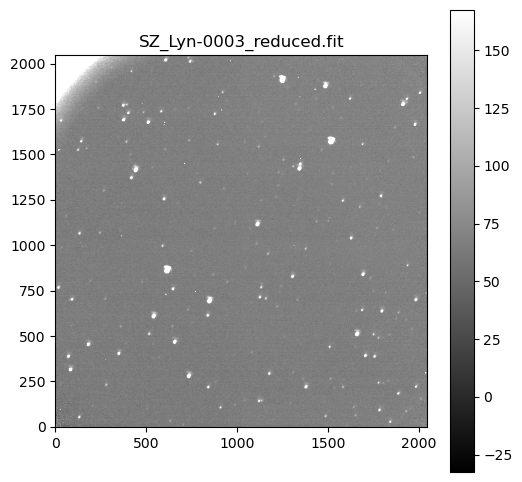

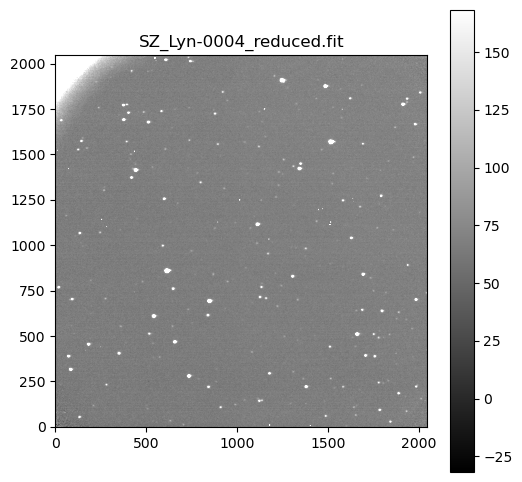

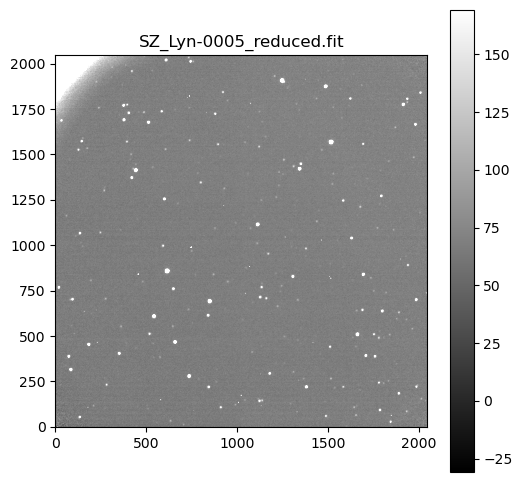

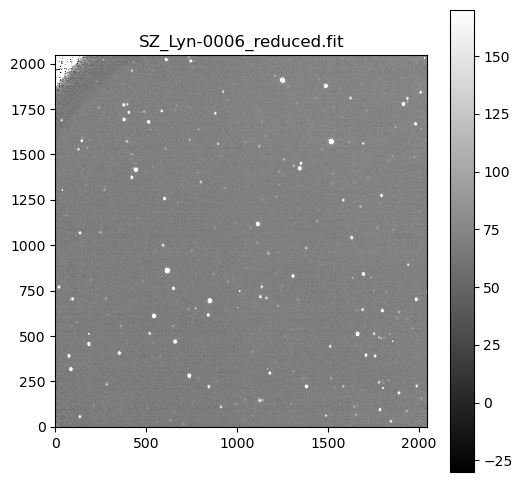

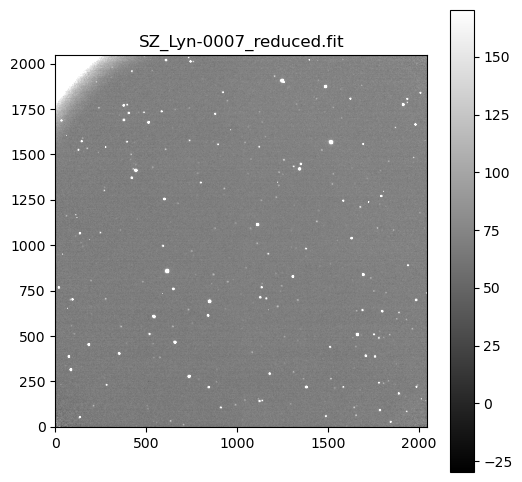

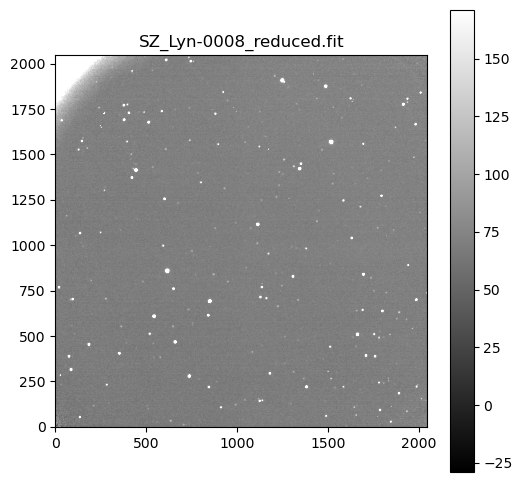

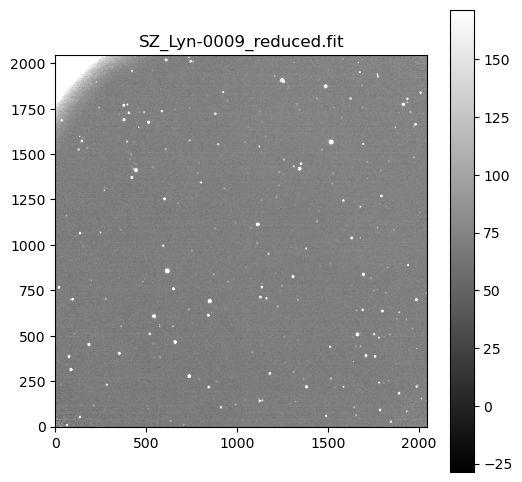

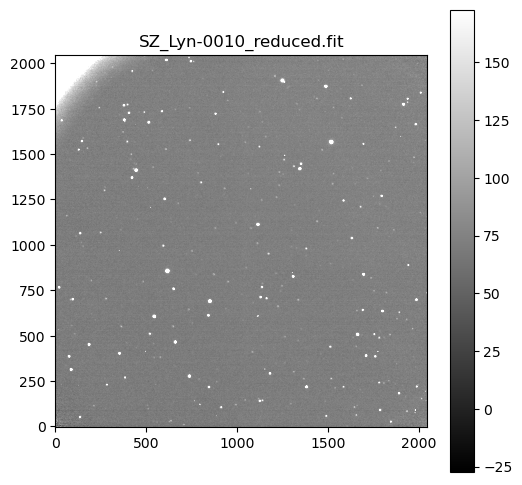

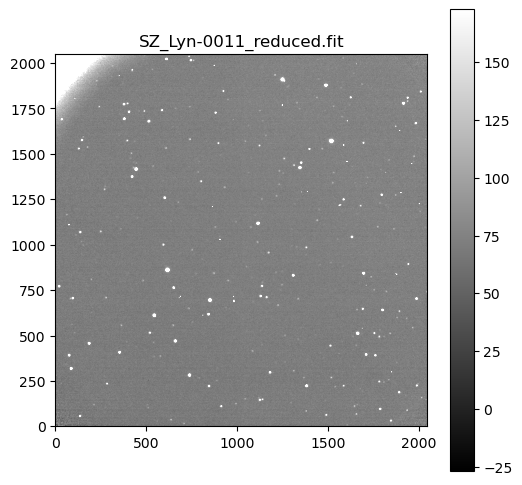

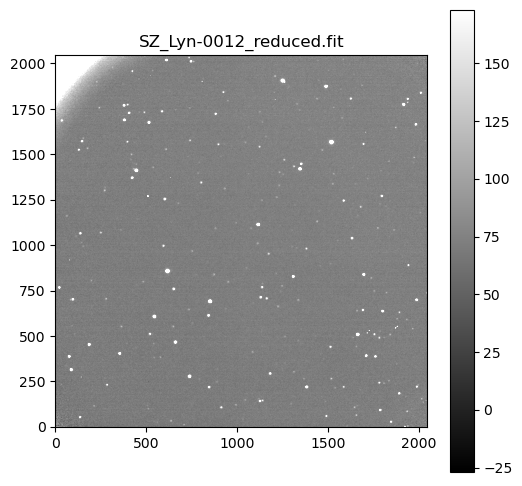

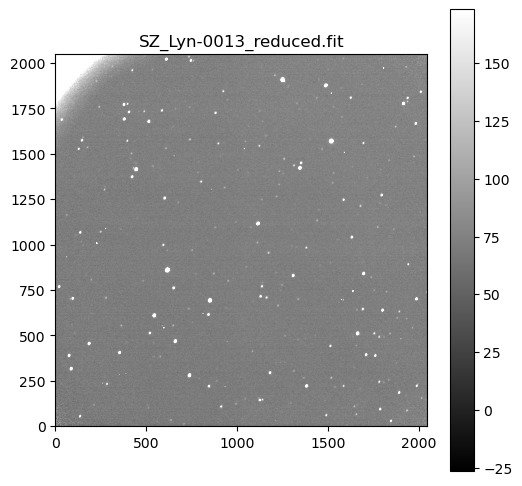

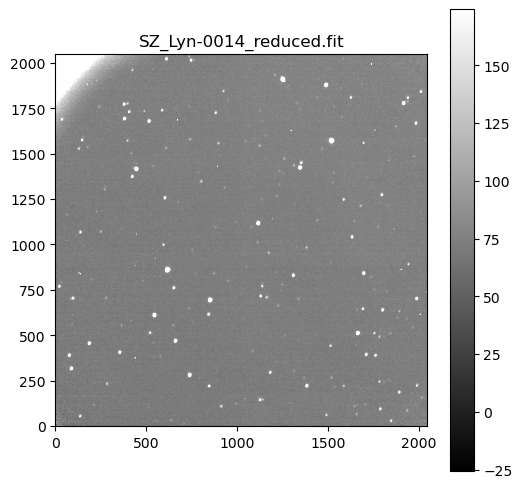

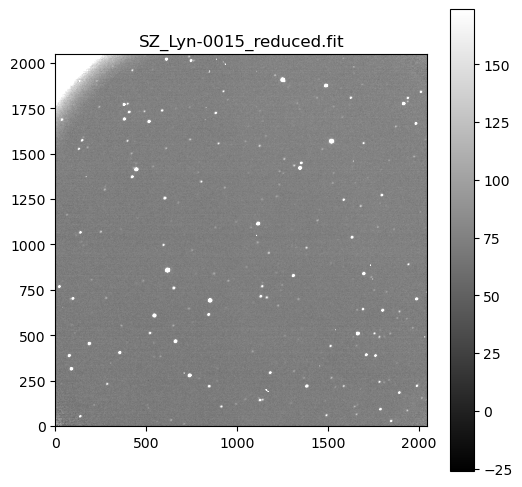

KeyboardInterrupt: 

In [5]:
# --- ESECUZIONE ---

# Percorso principale al dataset
if __name__ == "__main__":
    path = '/Users/claudiamurro/Desktop/laboratorio tecnologie astronomiche/cupani'
    batch_reduce_images(path)

In [7]:
#rifar girare il codice per vedere tutti i frame ridotti